# Introduction

In this notebook our primary focus is on forecasting using the SARIMAX model. We have already completed the initial stages of exploratory data analysis, allowing us to transition to the forecasting phase.

We'll employ the SARIMAX model to generate forecasts based on historical data patterns. The SARIMAX model combines autoregressive and moving average components, seasonal effects, and the inclusion of exogenous variables to facilitate accurate time series forecasting. We'll follow a structured approach, including model selection, parameter estimation, and diagnostic assessments to effectively apply SARIMAX modeling for forecasting purposes. Our ultimate objective is to provide you with practical insights and examples that can be readily applied to diverse real-world scenarios, enabling data-driven decision-making and predictive analysis. This hands-on approach will provide valuable insights and real-world examples that can be readily applied to a diverse range of scenarios, enabling data-driven decision-making and predictive analysis within the confines of this single Jupyter notebook.

## The SARIMAX model

The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) model is a powerful time series forecasting technique that extends the traditional ARIMA (Autoregressive Integrated Moving Average) model by incorporating seasonal and exogenous components (external factor that influences the time series data). SARIMAX is designed to model and predict time-dependent data that exhibit both non-seasonal and seasonal patterns, making it highly flexible and widely used in various domains such as finance, economics, and demand forecasting.

### Components of SARIMAX

**Seasonal Component (S):** SARIMAX introduces a seasonal component to account for periodic patterns in the data. This component is denoted by **(P, D, Q, s)**, where:

- **P:** The seasonal autoregressive order represents the number of seasonal lags in the autoregressive part.
- **D:** The seasonal differencing order indicates the number of seasonal differences needed to achieve stationarity.
- **Q:** The seasonal moving average order represents the number of seasonal lags in the moving average part.
- **s:** The seasonal period defines the number of time steps in each seasonal cycle (e.g., 12 for monthly data with an annual seasonality).

**Non-Seasonal Component (p, d, q):** The non-seasonal component of SARIMAX follows the same principles as the traditional ARIMA model:

- **p:** The autoregressive order represents the number of non-seasonal lags in the autoregressive part.
- **d:** The differencing order indicates the number of differences needed to make the data stationary.
- **q:** The moving average order represents the number of non-seasonal lags in the moving average part.

**Exogenous Regressors (X):** SARIMAX allows for the inclusion of exogenous variables that can enhance the model's predictive capability. Exogenous variables are external factors that can influence the time series being forecasted. These variables can be incorporated into the model as additional features to capture their impact on the target variable.

### Modeling and Forecasting Process

The process of building a SARIMAX model begins with identifying the appropriate values of (p, d, q) and (P, D, Q, s). This is typically done by analyzing the autocorrelation and partial autocorrelation plots of the time series data. Autocorrelation (ACF) and partial autocorrelation (PACF) plots are graphical tools used in time series analysis to understand the correlation structure within a dataset. They help identify the appropriate orders (p and q) for the autoregressive (AR) and moving average (MA) components of a time series model, such as the ARIMA or SARIMAX model.

The ACF plot (Figure 1) displays the correlation between a time series and its lagged values, where "lag" refers to the time delay or number of time steps between data points. It helps identify the order of the moving average (MA) component in a time series model. Peaks or significant spikes in the ACF plot indicate the number of lag values to consider for the MA component of the model.

In contrast, the PACF plot (Figure 2) displays the correlation between a time series and its lagged values while removing the effect of shorter lags through partial correlation. It helps identify the order of the autoregressive (AR) component in a time series model. Peaks or significant spikes in the PACF plot indicate the number of lag values to consider for the AR component of the model. The PACF values at lags beyond these significant spikes are assumed to be zero.

<div style="display: flex;">
  <div style="flex: 50%; padding: 10px;">
    <img src="imgs/acf.png" alt="Figure 1">
    <p>Figure 1 - Autocorrelation plot</p>
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="imgs/pacf.png" alt="Figure 2">
    <p>Figure 2 - Partial autocorrelation plot</p>
  </div>
</div>


Once the parameters are determined, the SARIMAX model is constructed using the specified values. The model is then fitted to the training data to capture the historical patterns and relationships.

After fitting the model, it can be used to make future predictions for the time series data. Forecasts can include both point forecasts and prediction intervals, providing a range of potential outcomes.

To assess the effectiveness of the SARIMAX model, various evaluation metrics are employed, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or other relevant metrics. These metrics help quantify the accuracy of the model's forecasts and its ability to capture the underlying patterns in the data.

### Advantages of SARIMAX

- Flexibility to capture both non-seasonal and seasonal patterns in time series data.
- Incorporates external factors through exogenous variables, making it applicable to a wide range of forecasting scenarios.
- Offers a systematic approach to modeling and forecasting with a clear parameter specification process.
- Provides interpretable results and diagnostics for model assessment.

### Limitations

- SARIMAX models may not perform well on highly irregular or chaotic time series data.
- Determining the appropriate model order can be a manual and iterative process.
- May require a relatively large amount of historical data to make accurate forecasts, especially for seasonal patterns.

In summary, the SARIMAX model is a versatile and powerful tool for time series forecasting, allowing data scientists and analysts to capture and predict complex temporal patterns, both seasonal and non-seasonal, while accommodating the influence of exogenous variables. It is widely used in business and research applications where historical data analysis and future predictions are crucial for decision-making.

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

# Feature Engineering

In this step, we'll collect the sales data from a sample store. This data will be used to train our ARIMA model. For this we'll check if the data is starionary, outliers that must me handled and if we need to transfom data for training.

## Load saved data

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(os.path.join(processed_data_folder, "stores-sales.parquet"))
stores_sales_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfMonth,Week,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,31,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
2015-07-30,1,3,5020,546,1,1,0,1,30,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
2015-07-29,1,2,4782,523,1,1,0,1,29,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
2015-07-28,1,1,5011,560,1,1,0,1,28,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
2015-07-27,1,0,6102,612,1,1,0,1,27,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771,339,1,0,0,1,5,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2013-01-04,1115,4,4540,326,1,0,0,1,4,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2013-01-03,1115,3,4297,300,1,0,0,1,3,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


## Collect sample store

In [4]:
sample_store_sales = (
    stores_sales_df[stores_sales_df["Store"] == 2]
)["Sales"]

sample_store_sales

Date
2015-07-31    6064
2015-07-30    5567
2015-07-29    6402
2015-07-28    5671
2015-07-27    6627
              ... 
2013-01-05    2342
2013-01-04    4484
2013-01-03    4159
2013-01-02    4422
2013-01-01       0
Name: Sales, Length: 942, dtype: int64

### Time Series Stationarity

Time series data often exhibit patterns, trends, and fluctuations over time, and one critical aspect in time series analysis is determining whether the data is stationary. Stationarity is a fundamental assumption for many time series models and is critical to produce reliable forecasts.

Trend and seasonality can significantly impact the performance of the ARIMA forecast model. Here's some examples why:
- If a strong trend is present in the time series data, the ARIMA model might attempt to capture this trend in the auto-regressive (AR) component, leading to overfitting.
- Seasonal patterns can introduce bias into forecasts if not properly accounted for. ARIMA models may produce predictions that do not align with the known seasonal patterns, leading to inaccurate forecas

There are many ways to check for time series stationarity. Here, we'll use a combination of the three most popular ones:

**Visual Inspection:** A simple yet insightful way to start is with visual inspection. Plot the time series data and examine it closely. Look for trends, seasonality, and any apparent variations in mean or variance. Visual inspection is a preliminary step that can provide valuable insights.

**Augmented Dickey-Fuller (ADF) Test:** The ADF test is a statistical hypothesis test used to formally assess stationarity. It focuses on the null hypothesis that the time series is non-stationary. A low p-value (typically less than 0.05) leads to rejecting the null hypothesis, indicating stationarity.
The ADF test checks for the presence of a unit root, which is a root in the autoregressive (AR) component of the time series model. If the data has a unit root, it suggests non-stationarity.

**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:** In contrast to the ADF test, the KPSS test examines the null hypothesis that the time series is stationary around a deterministic trend. The KPSS test can be used to identify stationary data with trend components.
A high p-value from the KPSS test suggests that the data is stationary around a deterministic trend, which is different from the ADF test that assumes non-stationarity.

These three approaches, when used in combination, provide a comprehensive assessment of time series stationarity. Visual inspection offers an initial understanding of the data's characteristics, while formal hypothesis tests like the ADF and KPSS tests provide quantitative evidence.

### Check for trend and seasonality

Use seasonal decomposition techniques to separate the time series into its trend, seasonal, and residual components. Python's **statsmodels** library provides the **seasonal_decompose** function for this purpose.

In [5]:
def plot_timeseries(series: pd.DataFrame):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(30, 7))
    
    decomposition = seasonal_decompose(series, model="additive", period=365)
    
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    ax1.plot(estimated_trend, color="blue")
    ax1.set_title("Trend")
    
    ax2.plot(estimated_seasonal, color="red")
    ax2.set_title("Seasonal")
    
    ax3.plot(estimated_residual, color="green")
    ax3.set_title("Residual")
    
    fig.suptitle("Decomposition Plots", y=1.01)
    
    plt.tight_layout()
    plt.show()

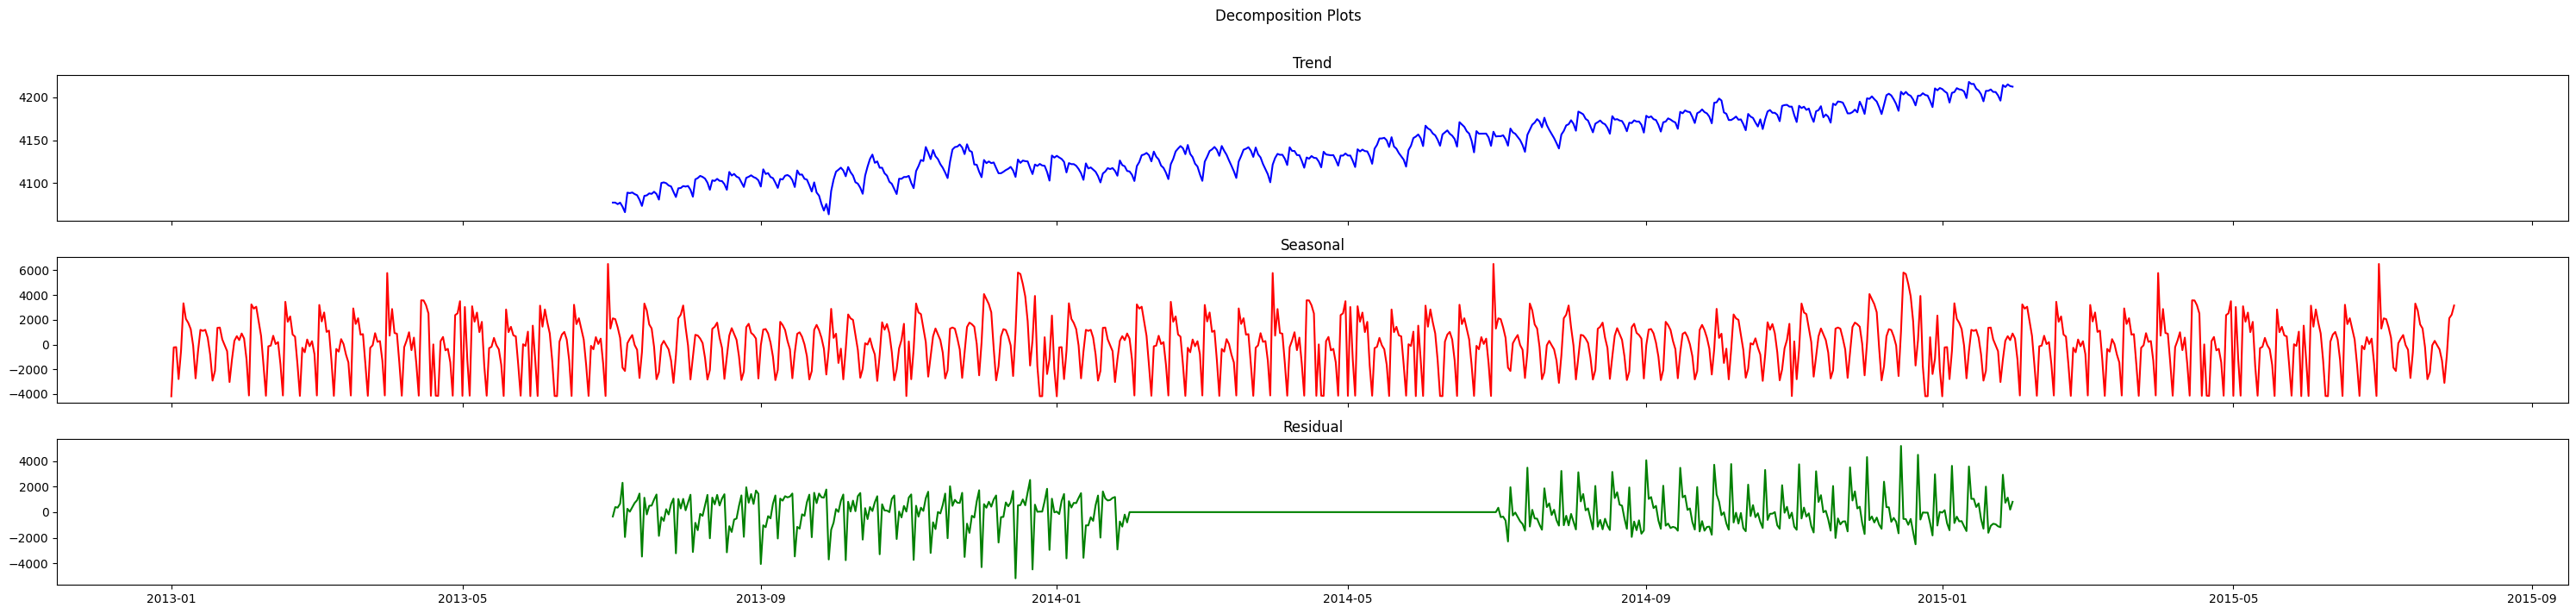

In [6]:
plot_timeseries(sample_store_sales)

- The **trend** shows a small trend in data. Well check if this affect our approach in a moment.
- The **sasonal** component is strong, and our future prediction model must take this in consideration.
- The strong **residual** component indicates that we must check for outliers and exogenous features to help our prediction model.

### Check for Stationarity

In [7]:
def test_stationarity(series: pd.DataFrame, confidence: float = 0.05) -> None:
    roll_mean = series.rolling(window=7).mean()
    roll_std = series.rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(30, 3))
    fig.suptitle("Time series rolling statistics")
    
    ax.plot(series.resample("W").mean(), color="blue", label="original")
    ax.plot(roll_mean.resample("W").mean(), color="red", label="Rolling Mean")
    ax.plot(roll_std.resample("W").mean(), color="green", label="Rolling STD")
    ax.legend(loc="best")
    plt.show()
    
    adfuller_results = adfuller(series, autolag="AIC")
    records1 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            adfuller_results[:3]
        )
    }
    for key, value in adfuller_results[4].items():
        records1[f"Critical Value ({key})"] = value
    
    kpss_results = kpss(series, nlags="auto")
    records2 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            kpss_results[:3]
        )
    }
    for key, value in kpss_results[3].items():
        records2[f"Critical Value ({key})"] = value
    
    results_df = pd.DataFrame.from_records((records1, records2), index=[
        "ADF", "KPSS"
    ])
    display(results_df.T)
    
    adf_stationarity = records1["p-value"] < confidence
    kpss_stationarity = records2["p-value"] > confidence
    
    print(f"ADF stationarity: {adf_stationarity} -- KPSS stationarity: {kpss_stationarity}")

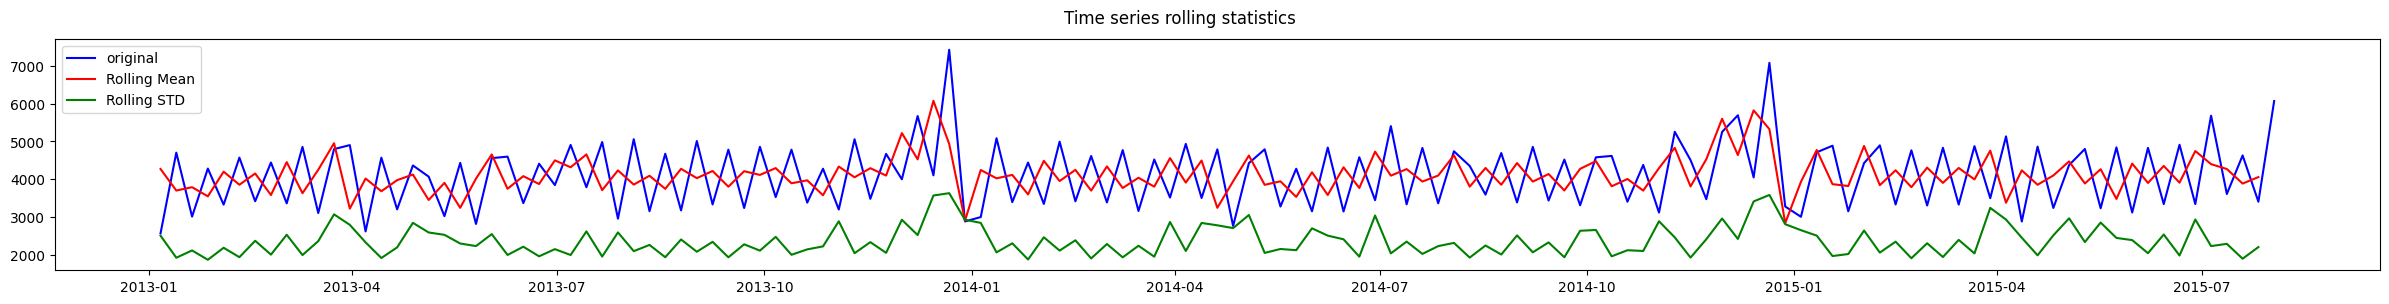

,ADF,KPSS
Test Statistic,-6.218237e+00,0.300305
p-value,5.300863e-08,0.100000
# Lags Used,2.100000e+01,53.000000
Critical Value (1%),-3.437478e+00,0.739000
Critical Value (5%),-2.864687e+00,0.463000
Critical Value (10%),-2.568445e+00,0.347000
Critical Value (2.5%),NaN,0.574000


ADF stationarity: True -- KPSS stationarity: True


In [8]:
test_stationarity(sample_store_sales)

By visual inspection, we can conclude that, despite the pontual fluctuations, we don't have a trend in the mean and variance of the data, which my indicate stationarity.

The quantitative testes results are:
- The p-value lower than 0.05 for the ADF test indicates that we can reject the nul-hypothesis of the data is non-stationary.
- The p-value higher than 0.05 for the KPSS test indicates that we cannot reject the null hypothesis that the data is stationary around a deterministc trend.

With this, we can safetly assume the data as **trend stationary**.

# Model Selection

Choosing an appropriate machine learning model for time series forecasting. Common models for time series forecasting include ARIMA, Prophet, and various machine learning algorithms such as Random Forest, XGBoost, or LSTM (Long Short-Term Memory).

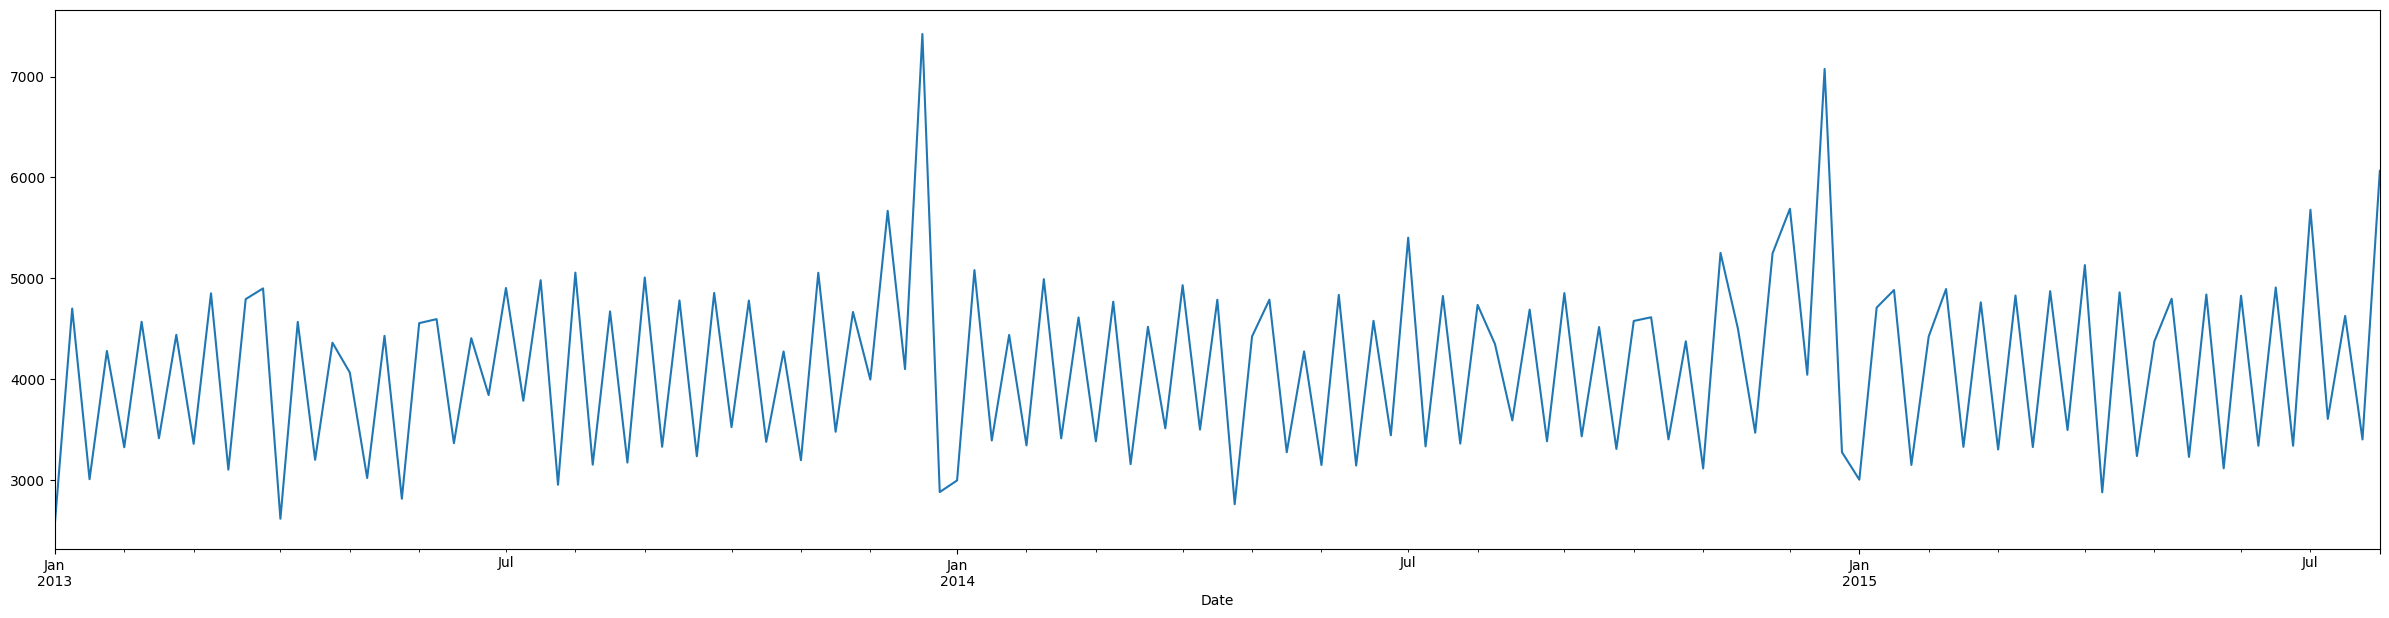

In [9]:
sarimax_dataset = sample_store_sales.resample("W").mean()

sarimax_dataset.plot(kind="line", figsize=(30, 7));

In [10]:
data_len = len(sarimax_dataset.index)
test_len = int(data_len * 0.2)

train_df = sarimax_dataset.iloc[:-test_len+1]
test_df = sarimax_dataset.iloc[-test_len:]

display(train_df)
display(test_df)

Date
2013-01-06    2567.833333
2013-01-13    4702.000000
2013-01-20    3011.571429
2013-01-27    4281.857143
2013-02-03    3328.142857
                 ...     
2015-01-04    3007.142857
2015-01-11    4711.571429
2015-01-18    4885.142857
2015-01-25    3152.857143
2015-02-01    4426.000000
Freq: W-SUN, Name: Sales, Length: 109, dtype: float64

Date
2015-02-01    4426.000000
2015-02-08    4895.285714
2015-02-15    3332.142857
2015-02-22    4763.285714
2015-03-01    3306.142857
2015-03-08    4830.714286
2015-03-15    3329.857143
2015-03-22    4874.000000
2015-03-29    3498.857143
2015-04-05    5132.428571
2015-04-12    2881.571429
2015-04-19    4861.857143
2015-04-26    3241.285714
2015-05-03    4374.571429
2015-05-10    4798.857143
2015-05-17    3232.285714
2015-05-24    4841.285714
2015-05-31    3119.714286
2015-06-07    4828.428571
2015-06-14    3343.285714
2015-06-21    4910.428571
2015-06-28    3343.000000
2015-07-05    5679.571429
2015-07-12    3609.142857
2015-07-19    4628.428571
2015-07-26    3405.428571
2015-08-02    6066.200000
Freq: W-SUN, Name: Sales, dtype: float64

## SARIMA

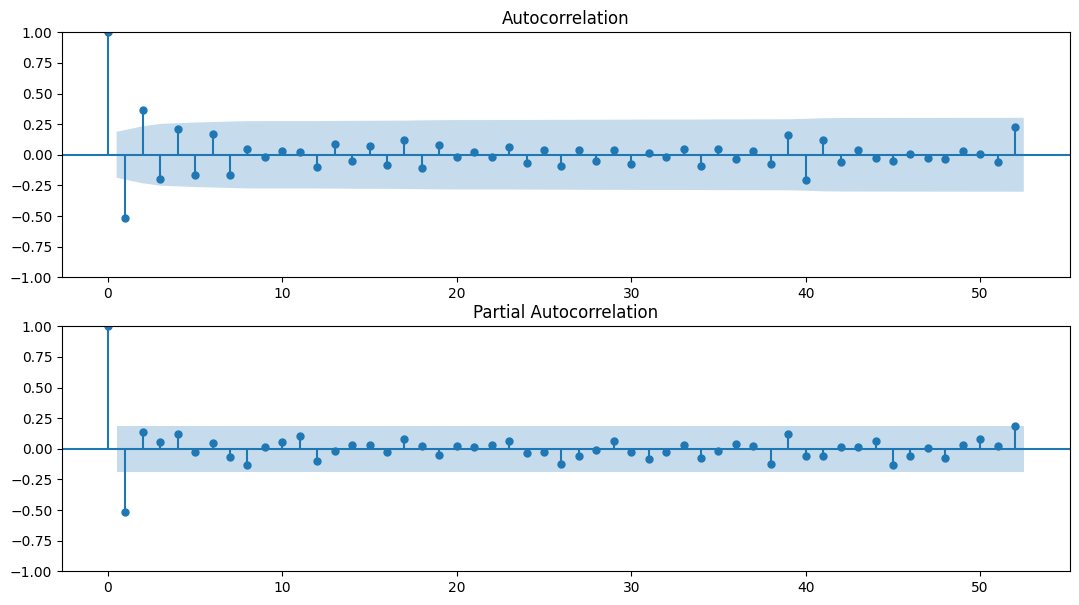

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 7))

sm.graphics.tsaplots.plot_acf(train_df, lags=52, ax=ax1)
sm.graphics.tsaplots.plot_pacf(train_df, lags=52, ax=ax2)

plt.show()

# Model Training

Using historical data to train the selected model. We will use a portion of the data for training and hold out another portion for evaluation.

In [12]:
auto_arima_results = auto_arima(
    train_df,
    start_p=0,
    start_q=0,
    d=0,
    max_p=2,
    max_q=2,
    max_d=2,
    start_P=1,
    start_Q=1,
    D=0,
    max_P=2,
    max_Q=2,
    max_D=1,
    max_order=5,
    m=52,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1793.020, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1758.464, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2130.221, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1760.108, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=11.58 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=14.18 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=1794.768, Time=0.24 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1752.318, Time=1.33 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1760.044, Time=0.03 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=11.67 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 52)   Log Likelihood                -867.605
Date:                              Sat, 04 Nov 2023   AIC                           1745.210
Time:                                      17:08:14   BIC                           1758.667
Sample:                                  01-06-2013   HQIC                          1750.667
                                       - 02-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5413.5535   1138.425      4.755      0.000    3182.282    7644.826
ar.L1         -0.4744      0.182     -2.602      0.009      -0.832      -0.117
ar.L2          0.1558      0.102      1.526      0.127      -0.044       0.356
ma.S.L52       0.4781      0.190      2.518      0.012       0.106       0.850
sigma2      5.523e+05   1.04e+05      5.304      0.000    3.48e+05    7.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                72.55
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             1.08
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

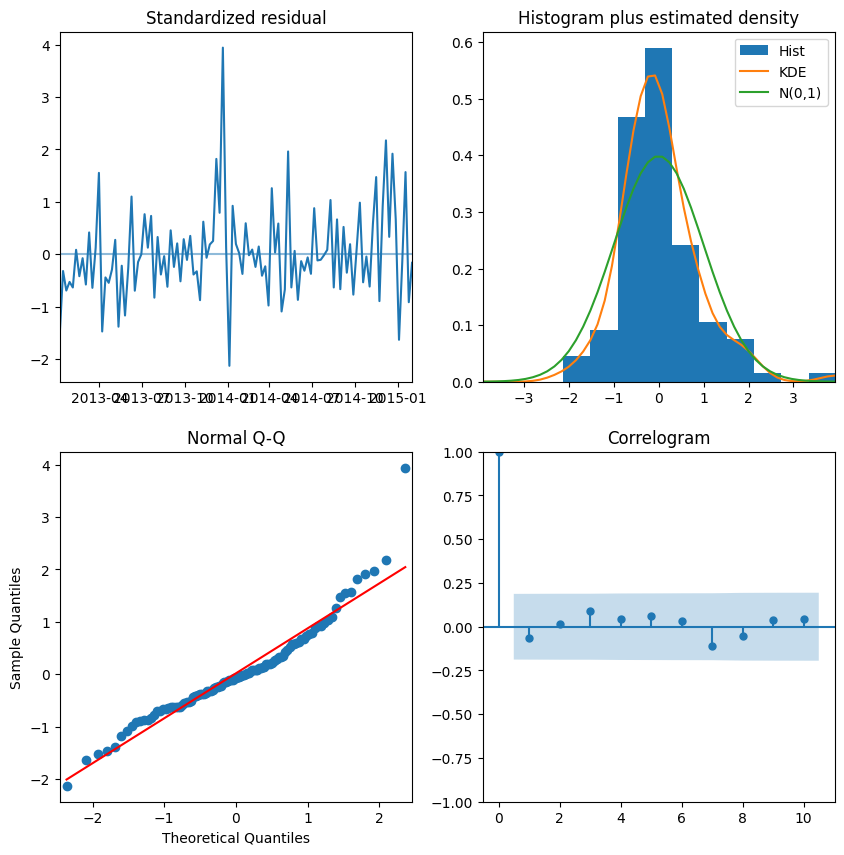

In [13]:
auto_arima_results = auto_arima_results.fit(train_df)

auto_arima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

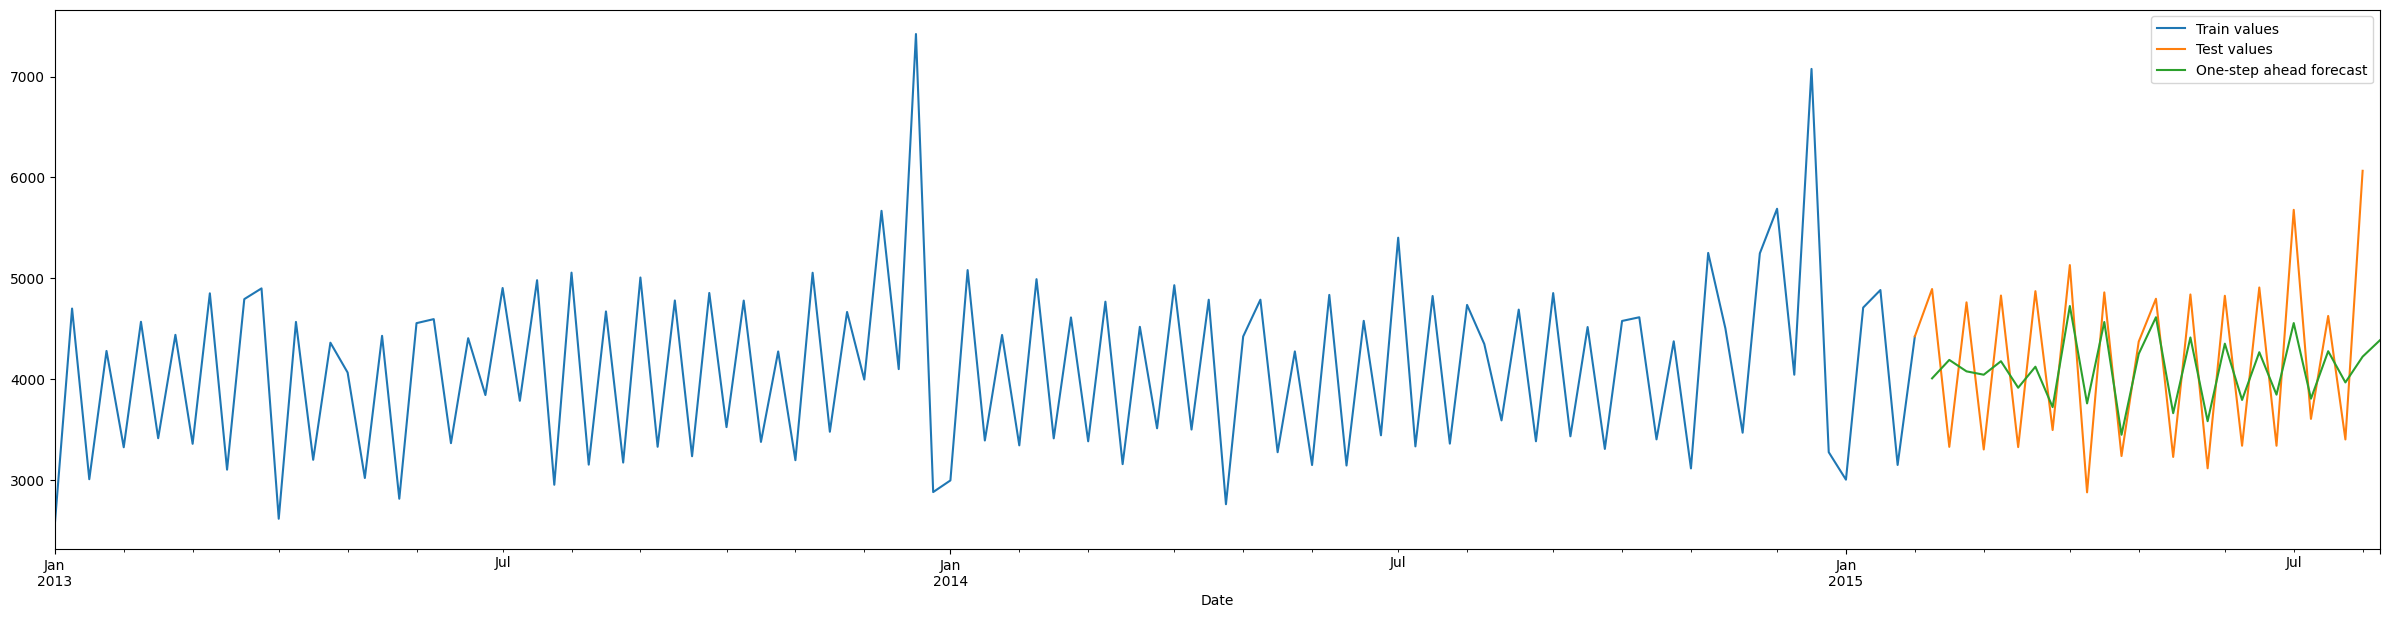

In [14]:
train_preds = auto_arima_results.predict(n_periods=len(test_df))

ax = train_df.plot(label="Train values", kind="line", figsize=(30, 7))
test_df.plot(label="Test values", kind="line", ax=ax)
train_preds.plot(label="One-step ahead forecast", kind="line", ax=ax)

plt.legend();

In [15]:
sarima_model = SARIMAX(
    train_df,
    **auto_arima_results.get_params()
)

sarima_results = sarima_model.fit(disp=False)

sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  109
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 52)   Log Likelihood                -892.634
Date:                              Sat, 04 Nov 2023   AIC                           1793.268
Time:                                      17:08:17   BIC                           1804.033
Sample:                                  01-06-2013   HQIC                          1797.633
                                       - 02-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1633      0.044      3.676      0.000       0.076       0.250
ar.L2          0.8095      0.044     18.412      0.000       0.723       0.896
ma.S.L52       0.9805      0.120      8.158      0.000       0.745       1.216
sigma2      4.355e+05   2.79e-07   1.56e+12      0.000    4.35e+05    4.35e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.02   Jarque-Bera (JB):                11.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.27e+27. Standard errors may be unstable.
"""

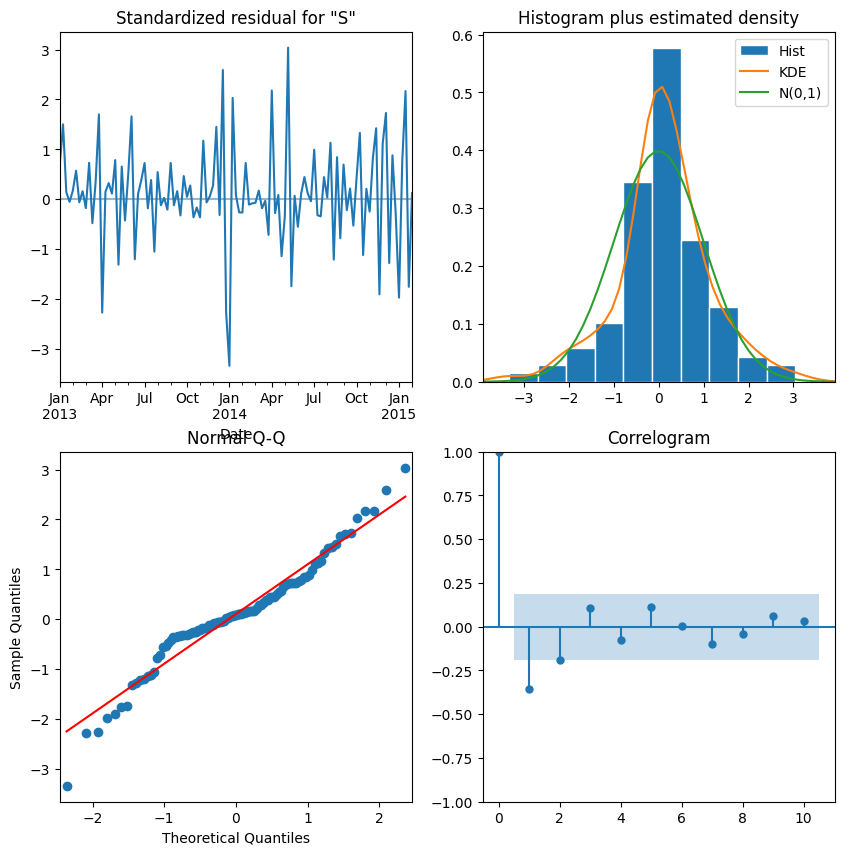

In [16]:
sarima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

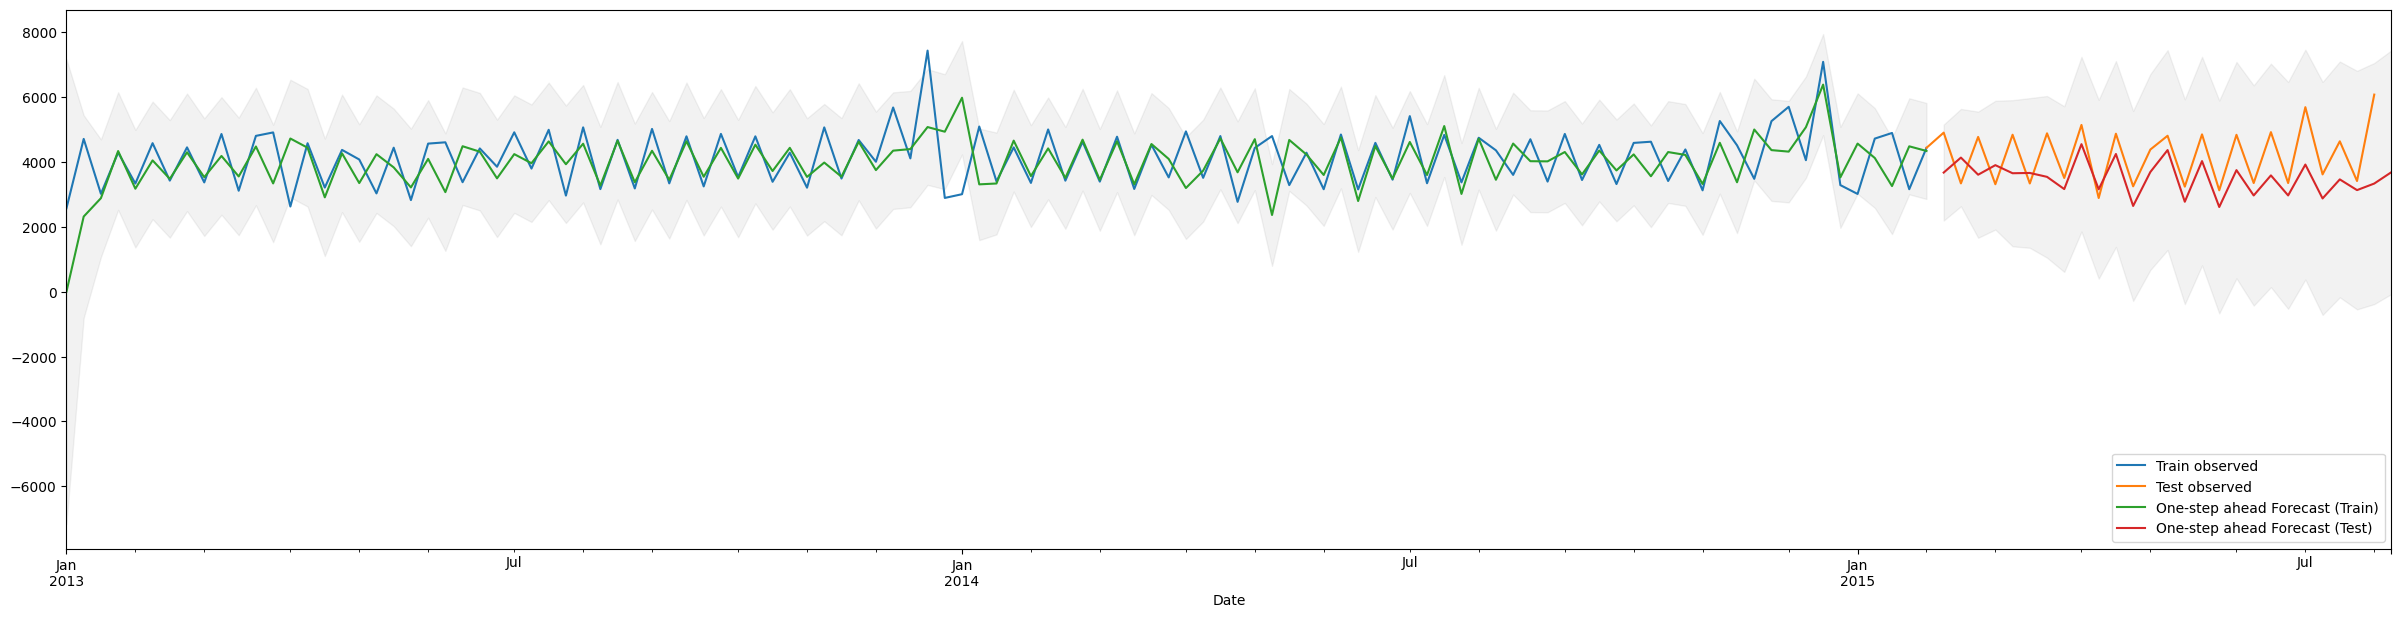

In [17]:
train_preds = sarima_results.get_prediction(dynamic=False)
train_preds_ci = train_preds.conf_int()

test_preds = sarima_results.get_forecast(steps=len(test_df), dynamic=False)
test_preds_ci = test_preds.conf_int()

ax = train_df.plot(label = "Train observed", figsize=(30, 7))
test_df.plot(label="Test observed")

train_preds.predicted_mean.plot(ax=ax, label="One-step ahead Forecast (Train)", alpha=1)
test_preds.predicted_mean.plot(label="One-step ahead Forecast (Test)", ax=ax)

ax.fill_between(
    train_preds_ci.index,
    train_preds_ci.iloc[:, 0],
    train_preds_ci.iloc[:, 1],
    color="k",
    alpha=0.05
)

ax.fill_between(
    test_preds_ci.index,
    test_preds_ci.iloc[:, 0],
    test_preds_ci.iloc[:, 1],
    color="k",
    alpha=0.05
)

plt.legend(loc="lower right");

In [18]:
test_preds.predicted_mean

2015-02-08    3665.454826
2015-02-15    4126.540996
2015-02-22    3599.369634
2015-03-01    3893.603544
2015-03-08    3644.960064
2015-03-15    3653.425792
2015-03-22    3533.474746
2015-03-29    3156.689187
2015-04-05    4539.876433
2015-04-12    3150.869993
2015-04-19    4237.732246
2015-04-26    2637.403266
2015-05-03    3683.542332
2015-05-10    4358.176641
2015-05-17    2767.261373
2015-05-24    4019.040983
2015-05-31    2605.285871
2015-06-07    3740.504750
2015-06-14    2960.043711
2015-06-21    3578.531606
2015-06-28    2961.625583
2015-07-05    3912.189812
2015-07-12    2868.362955
2015-07-19    3455.060196
2015-07-26    3125.128659
2015-08-02    3327.465118
2015-08-09    3678.910239
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Model Evaluation

Assessing the model's performance using evaluation metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

# Hyperparameter Tuning

Fine-tuning the model's hyperparameters to improve its performance.

# Forecasting

Using the trained model to make sales forecasts for future weeks, considering promotion indicators.

# Visualization and Interpolation

Visualizing the forecasted sales and interpreting the results. This may include identifying the impact of promotions on sales.

# Deployment

If necessary, deploying the model in a production environment for ongoing sales forecasting.